In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# This psf has flux as another parameter
psf_fits = fits.open('/home/aalvarez/Downloads/sim08/using_flux.psf')
psf_data = psf_fits['PSF_DATA']

In [3]:
psf_data.header

XTENSION= 'BINTABLE'           / THIS IS A BINARY TABLE (FROM THE LDACTOOLS)    
BITPIX  =                    8 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                25000 / BYTES PER ROW                                  
NAXIS2  =                    1 / NUMBER OF ROWS                                 
PCOUNT  =                    0 / RANDOM PARAMETER COUNT                         
GCOUNT  =                    1 / GROUP COUNT                                    
TFIELDS =                    1 / FIELDS PER ROWS                                
EXTNAME = 'PSF_DATA'           / TABLE NAME                                     
LOADED  =                  327 / Number of loaded sources                       
ACCEPTED=                  254 / Number of accepted sources                     
CHI2    =           1.31014792 / Final Chi2                                     
POLNAXIS=                   

In [4]:
class Poly(object):
    def __init__(self, psf_data):
        self._n_axis = psf_data.header['POLNAXIS']
        self._groups = list()
        self._names = list()
        self._offsets = list()
        self._scales = list()
        
        for i in range(1, self._n_axis + 1):
            self._groups.append(psf_data.header[f'POLGRP{i}'] - 1)
            self._names.append(psf_data.header[f'POLNAME{i}'])
            self._offsets.append(psf_data.header[f'POLZERO{i}'])
            self._scales.append(psf_data.header[f'POLSCAL{i}'])
            
        self._n_groups = psf_data.header['POLNGRP']
        self._degrees = list()
        for i in range(1, self._n_groups + 1):
            self._degrees.append(psf_data.header[f'POLDEG{i}'])
            
        self._n_coefs = psf_data.header['PSFAXIS3']
        
        self._powers = self._calculate_powers()
        self._coefs = psf_data.data[0][0]
            
    def _calculate_powers(self):
        exponents = np.zeros(self._n_axis, dtype=np.int)
        powers = np.zeros((self._n_coefs, self._n_axis), dtype=np.int)
        group_exponents = np.zeros(self._n_groups, dtype=np.int)
        group_exponents[:self._n_groups] = self._degrees
        
        # Constant
        powers[0,:] = 0
        if self._n_axis:
            group_exponents[self._groups[0]] -= 1
        
        # Polynom
        exponents[0] = 1
        pi = 1
        for t in reversed(range(1, self._n_coefs)):
            powers[pi,:] = exponents[:]
            pi += 1
            
            ei = 0
            for group in self._groups:
                if group_exponents[group]:
                    group_exponents[group] -= 1
                    exponents[ei] += 1
                    break
                else:
                    group_exponents[group] = exponents[ei]
                    exponents[ei] = 0
                    ei += 1
        
        return powers
    
    def get_powers(self):
        return self._powers
    
    def get_repr(self, i):
        if i == 0:
            return 'Constant'
        
        components = []
        for v, p in zip(self._names, self._powers[i,:]):
            if p != 0:
                components.append(f'{v}$^{p}$')
            
        return ' + '.join(components)
    
    def get_coefs(self, i):
        return self._coefs[i]
    
poly = Poly(psf_data)

<IPython.core.display.Javascript object>


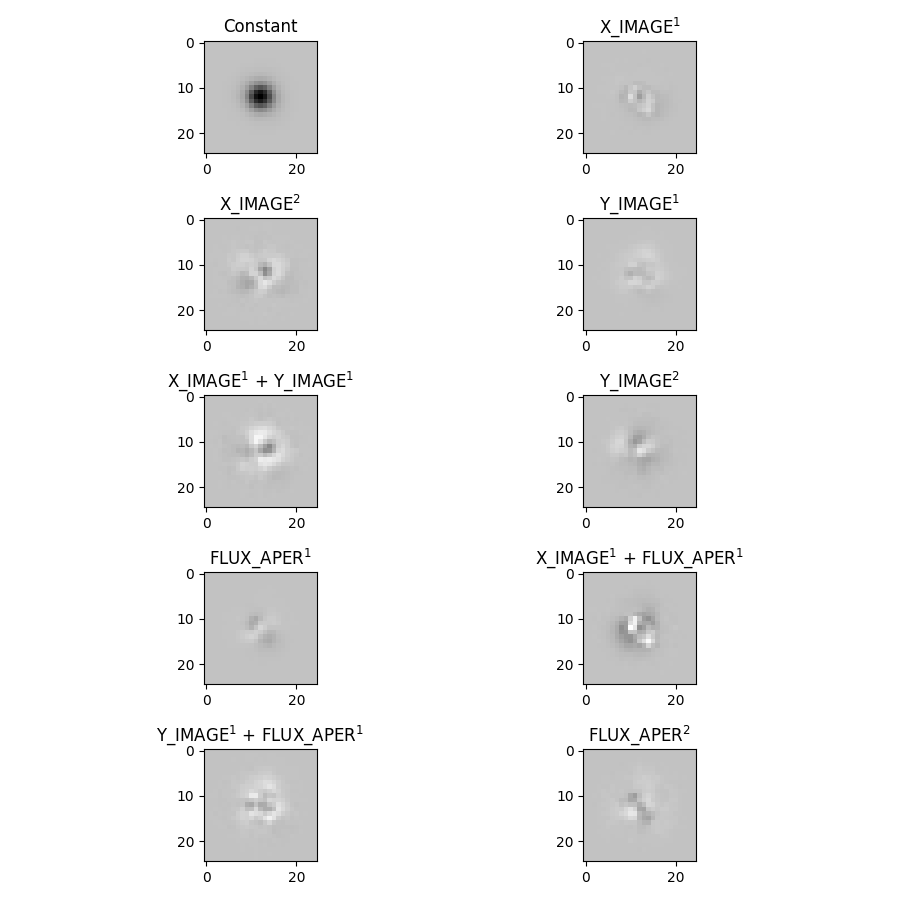

In [5]:
abs_min, abs_max = poly._coefs.min(), poly._coefs.max()
cmap = plt.get_cmap('binary')
norm = colors.Normalize(abs_min, abs_max)

ncols = 2
nrows = poly._n_coefs / ncols

plt.figure(figsize=(9, 9))
for i in range(0, poly._n_coefs):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(poly.get_coefs(i), cmap=cmap, norm=norm)
    plt.title(poly.get_repr(i))
            
plt.tight_layout()

In [6]:
pos_only = fits.open('/home/aalvarez/Downloads/sim08/sim08.psf')['PSF_DATA']

<IPython.core.display.Javascript object>


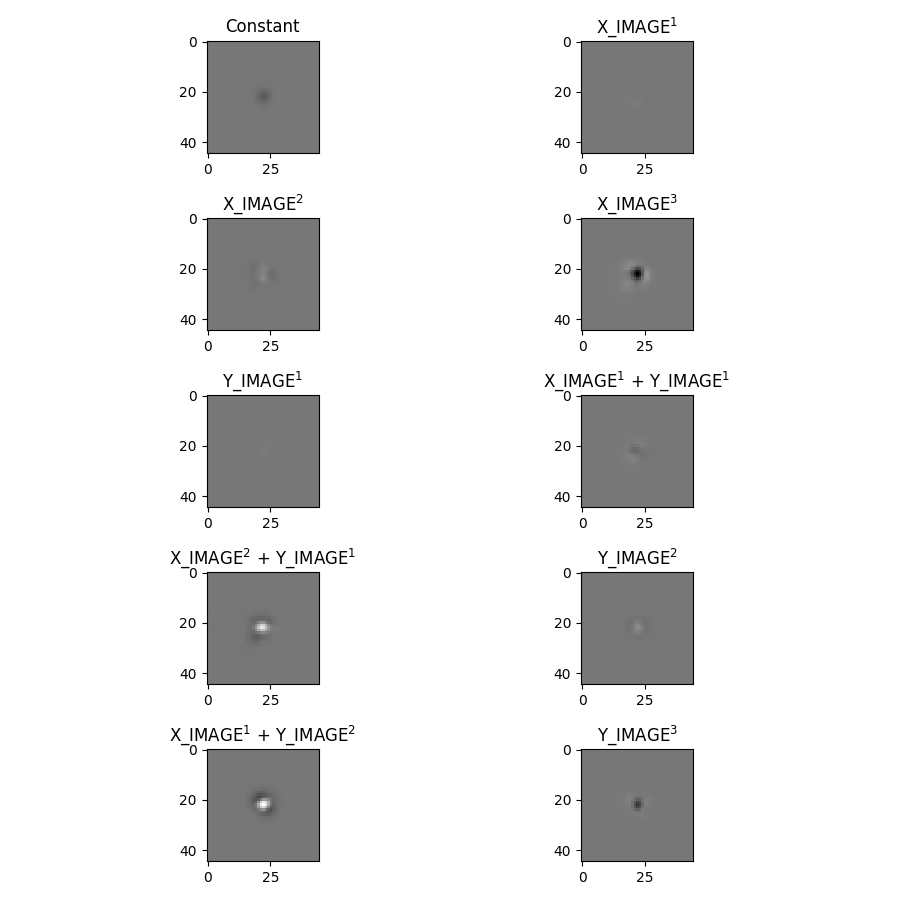

In [7]:
pol_pos = Poly(pos_only)

abs_min, abs_max = pol_pos._coefs.min(), pol_pos._coefs.max()
cmap = plt.get_cmap('binary')
norm = colors.Normalize(abs_min, abs_max)

ncols = 2
nrows = pol_pos._n_coefs / ncols

plt.figure(figsize=(9, 9))
for i in range(0, pol_pos._n_coefs):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(pol_pos.get_coefs(i), cmap=cmap, norm=norm)
    plt.title(pol_pos.get_repr(i))
            
plt.tight_layout()